In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator as LNDI
from scipy.interpolate import NearestNDInterpolator as NNDI

In [2]:
pd.options.display.max_colwidth = 100
%matplotlib notebook

### Load Dataset

In [3]:
cloud_filepath = r"C:\home\develop\pointcloud_experiment\out\build\x64-Release\plane_segment_sample_decimate0.9_clean.csv"
#cloud_filepath = r"C:\home\develop\pointcloud_experiment\out\build\x64-Release\20210108simizuP40-A-3_subsample0.0012_cylinder_origin_plane_decimate0.9_clean.csv"
coeffs_filepath = r"C:\home\develop\pointcloud_experiment\out\build\x64-Release\plane_segment_sample_decimate0.9_planecoeffs.csv"

In [4]:
save_dirpath = os.path.split(cloud_filepath)[0]
cloud_filename = os.path.split(cloud_filepath)[1]

In [5]:
# load pointcloud: x,y,z,region_id 
df = pd.read_csv(cloud_filepath, sep='\t')
df.describe()

,x,y,z,region_id
count,479816.000000,479816.000000,479816.000000,479816.000000
mean,0.018209,7.513122,5.177863,2.291678
std,0.609245,1.376142,0.002517,2.239282
min,-1.130560,4.976100,5.168770,0.000000
25%,-0.490658,6.355367,5.176590,0.000000
50%,0.058071,7.554085,5.177880,2.000000
75%,0.536189,8.692985,5.179400,4.000000
max,1.038390,9.885630,5.188560,6.000000


In [6]:
df_coeffs = pd.read_csv(coeffs_filepath, sep="\t")
df_coeffs

,region_id,a,b,c,d
0,0,0.001187,0.000092,0.999999,-5.17910
1,1,0.003620,0.003760,0.999986,-5.20086
2,2,0.002852,0.003518,0.999990,-5.19902
3,3,-0.002996,0.006719,0.999973,-5.24674
4,4,0.008952,-0.002859,0.999956,-5.15977
5,5,-0.002626,-0.000063,0.999997,-5.18062
6,6,0.011202,0.001709,0.999936,-5.19310


In [7]:
# extract index and retion_id
region_id_list = df_coeffs.region_id.values  # must be equal with df.region_id.drop_duplicates().values
region_id_list.sort()
for i in range(len(region_id_list)):
    print('index: %s region_id: %s' % (i, region_id_list[i]))
if len(region_id_list) != len(df.region_id.drop_duplicates()):
    print('Error: df and df_coeffs is not matched')

index: 0 region_id: 0
index: 1 region_id: 1
index: 2 region_id: 2
index: 3 region_id: 3
index: 4 region_id: 4
index: 5 region_id: 5
index: 6 region_id: 6


### Grid definition

In [8]:
dx = dy = 0.001
nx = int((np.max(df.x) - np.min(df.x)) / dx)
ny = int((np.max(df.y) - np.min(df.y)) / dy)
print('data size: (%s, %s)' % (nx, ny))
x = np.linspace(np.min(df.x), np.max(df.x), nx)
y = np.linspace(np.min(df.y), np.max(df.y), ny)
gx, gy = np.meshgrid(x, y)

data size: (2168, 4909)


### Plot settings

In [9]:
# common plot settings
def set_plot_label():
    plt.ylim(np.min(x), np.max(x))
    plt.xlim(np.min(y), np.max(y))
    plt.ylabel('Tunnel depth [m]')
    plt.xlabel('R*theta [m]')

def save_plot(filepath):
    plt.savefig(filepath, bbox_inches="tight", pad_inches=0.1, dpi=300, facecolor='white')

### Height map

In [10]:
def gz_height(region_id):
    x_arr = df[df.region_id == region_id].x
    y_arr = df[df.region_id == region_id].y
    z_arr = df[df.region_id == region_id].z
    interp = LNDI(list(zip(x_arr,y_arr)), z_arr)  # LNDI fill np.nan outside of cenvex hull
    return interp(gx, gy)  # return grid z

In [11]:
gz_height_list = []
for region_id in region_id_list:
    gz_height_list.append(gz_height(region_id))

<IPython.core.display.Javascript object>


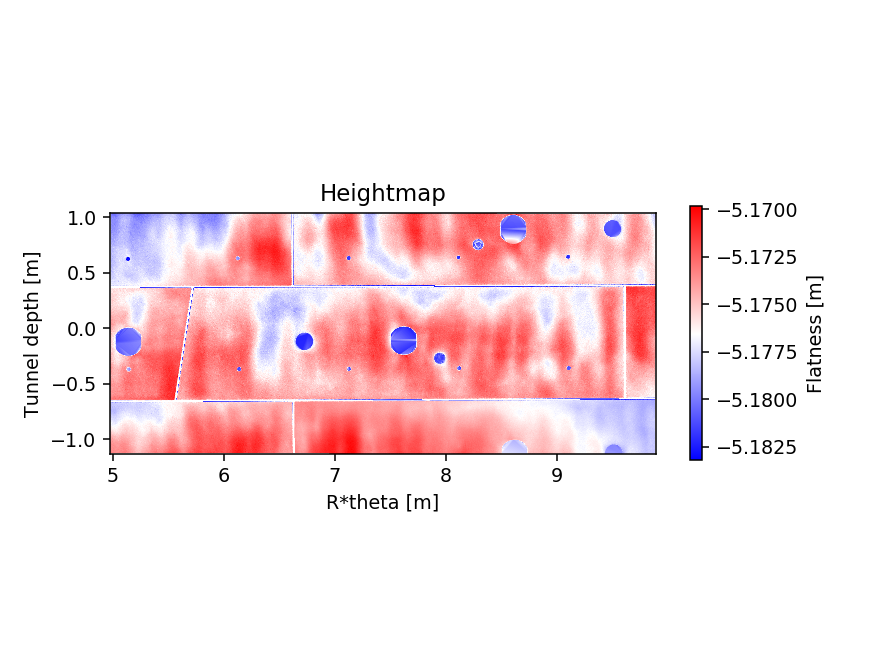

In [12]:
# visualize height ramp
fig_title = 'Heightmap'
for gz in gz_height_list:
    plt.imshow(-gz.transpose(), cmap='bwr', extent=[np.min(y), np.max(y), np.min(x), np.max(x)])
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('Flatness [m]')
set_plot_label()
plt.title(fig_title)
plt.show()
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))

### Region mask

In [13]:
# create region mask
# true: inside region  false: outside region
region_mask_list = []
for gz in gz_height_list:
    region_mask_list.append(~np.isnan(gz))
all_region_mask = np.zeros((ny, nx), dtype=bool)  # all false array
for mask in region_mask_list:
    all_region_mask = all_region_mask | mask

### Gap between regions

<IPython.core.display.Javascript object>


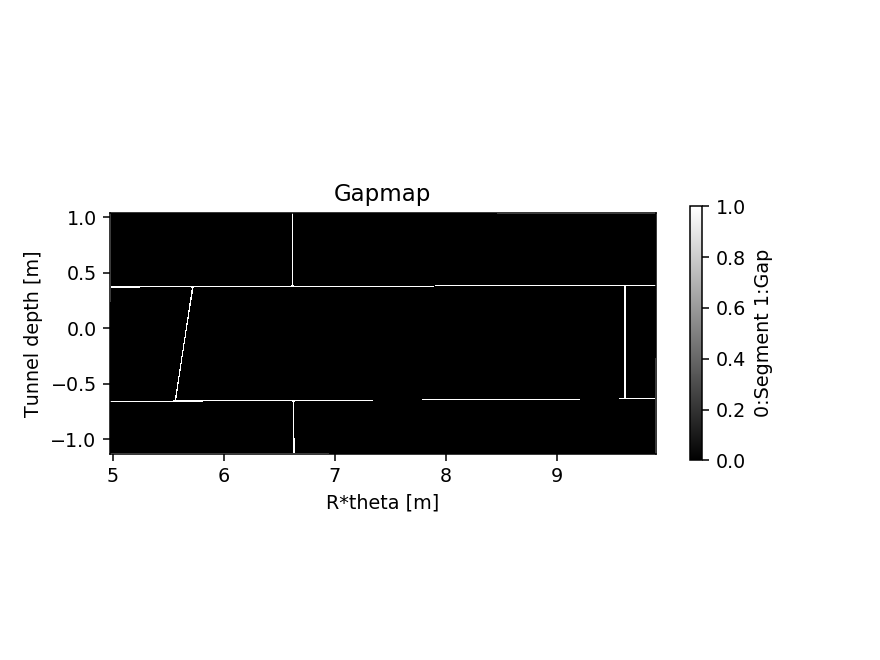

In [14]:
# visualize gap between regions
fig_title = 'Gapmap'
plt.imshow(~all_region_mask.transpose(), cmap='gray', extent=[np.min(y), np.max(y), np.min(x), np.max(x)], vmin=0, vmax=1)
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('0:Segment 1:Gap')
set_plot_label()
plt.title(fig_title)
plt.show()
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))

### Plane model reconstruction

In [15]:
def plane_coeffs(region_id):
    coeffs = df_coeffs[df_coeffs.region_id == region_id].values[0]  # df: region_id,a,b,c,d dataset
    return coeffs[1], coeffs[2], coeffs[3], coeffs[4]  # a, b, c, d in plane eq.

def z_model(x, y, *coeffs):
    a = coeffs[0][0]
    b = coeffs[0][1]
    c = coeffs[0][2]
    d = coeffs[0][3]
    return -(d + a*x + b*y) / c

def gz_model(region_id):
    coeffs = plane_coeffs(region_id)
    return z_model(gx, gy, coeffs)

In [16]:
gz_model_list = []
for i, region_id in enumerate(region_id_list):
    gz = gz_model(region_id)
    mask = region_mask_list[i]
    gz_masked = np.ma.masked_array(gz, ~mask, fill_value=np.nan)  # fill nan at outside region
    gz_model_list.append(gz_masked.filled())

<IPython.core.display.Javascript object>


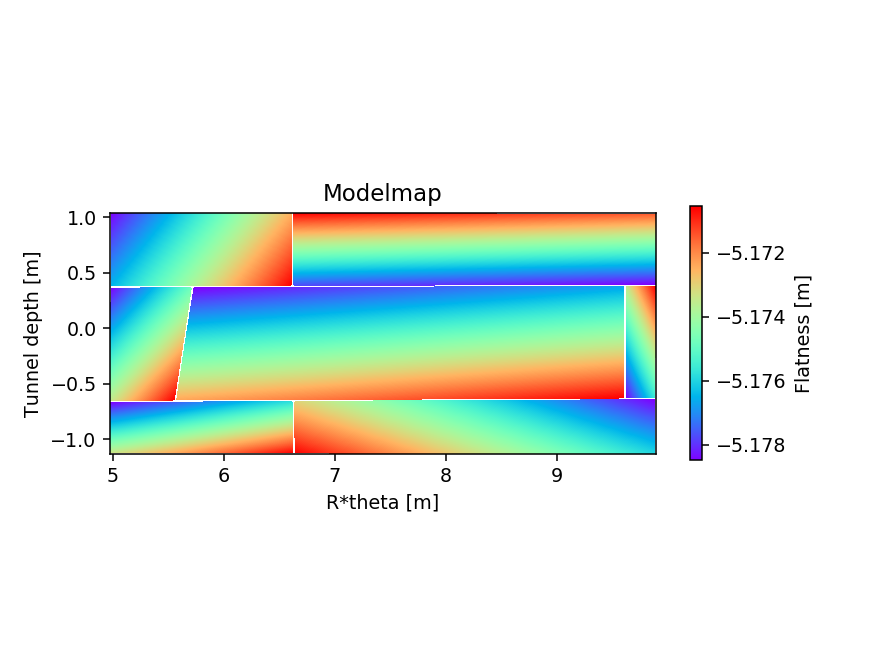

In [17]:
# visualize models
fig_title = 'Modelmap'
for gz in gz_model_list:
    plt.imshow(-gz.transpose(), cmap='rainbow', extent=[np.min(y), np.max(y), np.min(x), np.max(x)])
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('Flatness [m]')
set_plot_label()
plt.title(fig_title)
plt.show()
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))

### Region (Shield Tunnel Segment) map

In [18]:
gz_region_list = []
for i, region_id in enumerate(region_id_list):
    gz = np.zeros((ny, nx), dtype=float)  # must be float to use nan
    gz.fill(region_id)
    mask = region_mask_list[i]
    gz_masked = np.ma.masked_array(gz, ~mask, fill_value=np.nan)  # fill nan at outside region
    gz_region_list.append(gz_masked.filled())

<IPython.core.display.Javascript object>


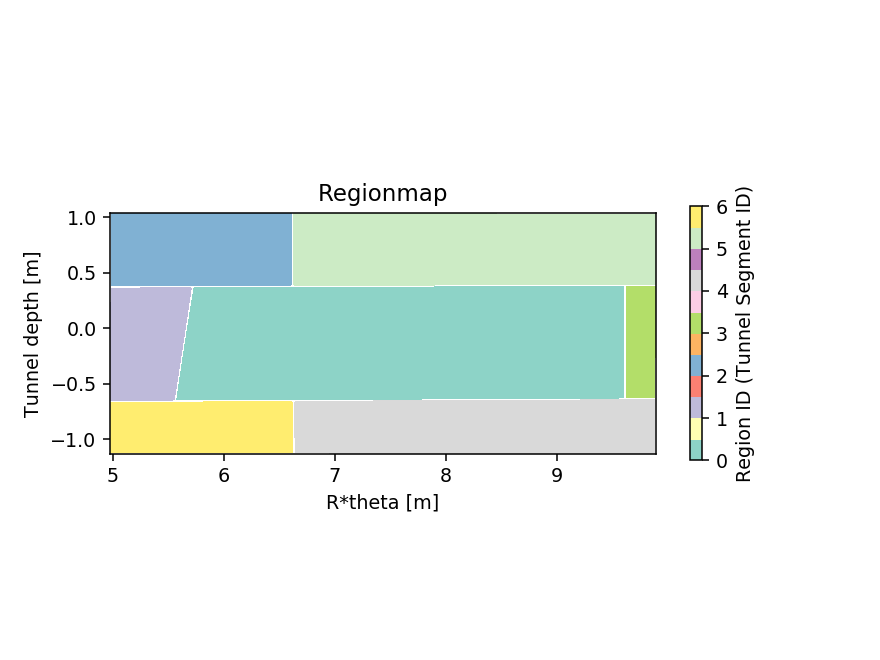

In [19]:
# visualize regions 
fig_title = 'Regionmap'
for gz in gz_region_list:
    plt.imshow(gz.transpose(), cmap='Set3', extent=[np.min(y), np.max(y), np.min(x), np.max(x)], vmin=np.min(region_id_list), vmax=np.max(region_id_list))
cbar = plt.colorbar(shrink=0.5)  # orientation='horizontal'
cbar.set_label('Region ID (Tunnel Segment ID)')
set_plot_label()
plt.title(fig_title)
plt.show()
save_plot(os.path.join(save_dirpath, cloud_filename + '_' + fig_title + '.png' ))

In [357]:
np.where(gz_region.filled() == 0)

(array([ 595,  595,  595, ..., 4622, 4622, 4622], dtype=int64),
 array([1679, 1680, 1681, ..., 1660, 1661, 1662], dtype=int64))

In [309]:
def replace_false_to_nan_2d(bool_map, target):
    if bool_map.shape != target.shape:
        return
    for i in range(bool_map.shape[0]):
        for j in range(bool_map.shape[1]):
            if not bool_map[i][j]:
                target[i][j] = np.nan

In [55]:
save_griddata_to_csv('region.csv.zip', gx_region, gy_region, gz_region)
gx, gy, gz = load_griddata_from_csv('region.csv.zip')

data size: (216, 490)
(490, 216)


<IPython.core.display.Javascript object>


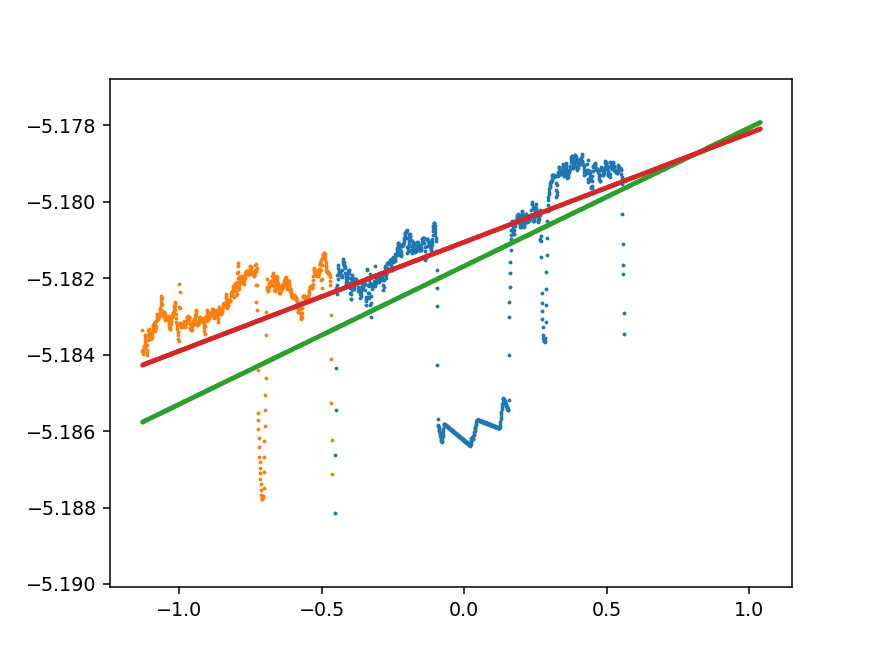

In [230]:
plt.scatter(gx[0], -gz1[150], s=1)
plt.scatter(gx[0], -gz2[150], s=1)
plt.scatter(gx[0], -z1, s=1)
plt.scatter(gx[0], -z2, s=1)

In [175]:
# create grid data
# x_arr, y_arr, z_arr: unorganized data set in np.array()
# resolution: 1 grid size
# interpolation_method: nearest, linear, cubic
# return grid of x, y, z
def resample_to_griddata(x_arr, y_arr, z_arr, resolution, interpolation_method='nearest'):
    dx = dy = resolution
    nx = int((np.max(x_arr) - np.min(x_arr)) / dx)
    ny = int((np.max(y_arr) - np.min(y_arr)) / dy)
    print('data size: (%s, %s)' % (nx, ny))
    x = np.linspace(np.min(x_arr), np.max(x_arr), nx)
    y = np.linspace(np.min(y_arr), np.max(y_arr), ny)
    gx, gy = np.meshgrid(x, y)
    points = np.array([x_arr, y_arr]).transpose()  # [x0,x1,...] and [y0,y1,...] ==> [[x0,y0], [x1,y1], ...]
    values = z_arr
    gz = griddata(points, values, (gx, gy), method=interpolation_method)
    return gx, gy, gz

In [229]:
x = gx[0]
y = gy[150][0]
a1,b1,c1,d1 = plane_coeffs(df_coeffs, 1)
a2,b2,c2,d2 = plane_coeffs(df_coeffs, 2)
z1 = model_z(x, y, a1, b1, c1, d1)
z2 = model_z(x, y, a2, b2, c2, d2)

<IPython.core.display.Javascript object>


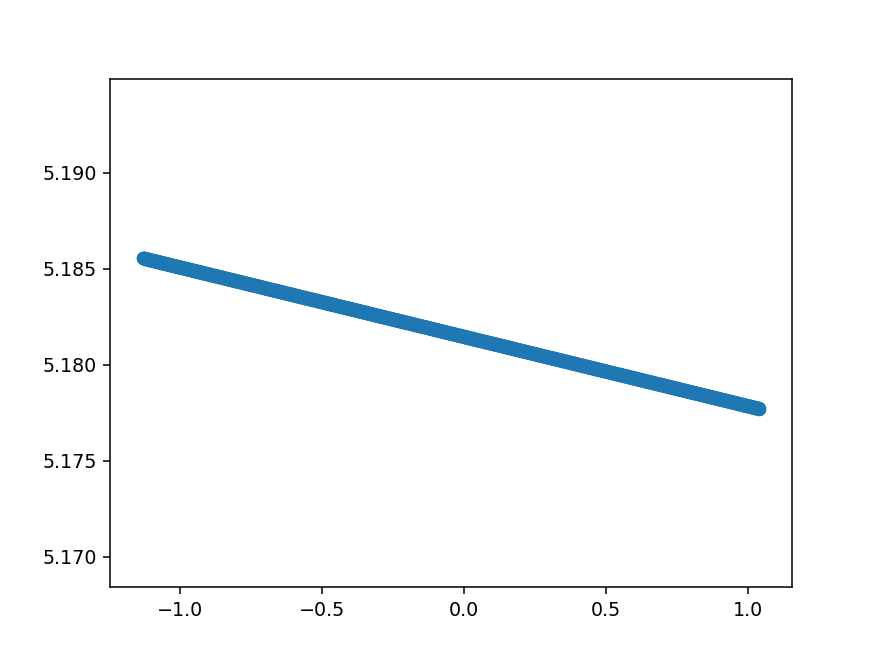

In [219]:
plt.scatter(x, z)

In [177]:
def save_griddata_to_csv(filepath, gx, gy, gz):
    if not gx.shape == gy.shape == gz.shape:
        print("Error: grid shape is not uniformed")
        return
    df = pd.DataFrame()
    df['x'] = gx.flatten()
    df['y'] = gy.flatten()
    df['z'] = gz.flatten()
    df.to_csv(filepath, sep='\t', index=None, header=True, compression='zip')

def load_griddata_from_csv(filepath):
    df = pd.read_csv(filepath, sep='\t', compression='zip')
    nx = len(df.x.drop_duplicates())
    ny = len(df.y.drop_duplicates())
    print('data size: (%s, %s)' % (nx, ny))
    gx = np.array(df.x).reshape(ny, nx)
    gy = np.array(df.y).reshape(ny, nx)
    gz = np.array(df.z).reshape(ny, nx)
    return gx, gy, gz